<a href="https://colab.research.google.com/github/masashi-hatano/RLIoT/blob/main/RL_ST_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The connection between Internet of Things equipment and services is today a major issue when applying such techniques for smart cities, especially for object detection. The different applications and systems require a fast response to enable a high-quality connection and security interconnection. This includes images collection, streaming and surveillance from cameras, and different types of telecommunications connections, such as Ethernet, Bluetooth, Wifi.
	
To work with the network formed by IOT applications, it is used Virtualized Networks Functions (VNF), where virtualized functions can be deployed on the edge network. And so, those functions are deployed according to the network capacities of CPU and bandwidth between CPUs to have a great accordance with the physical infrastructure capabilities.

To find an optimized solution to attend the network demand, on which physical node to deploy the virtual functions considering the resources of the network, it is used an approach based on a graph model. For instance, IOT chains are represented by trees and physical substrates by undirected graphs with a certain number of edges, and then the problem consists in optimizing the mapping of trees that corresponds to the constraints. The approximated problem and the solution will be better specified in the next sections.




# Problem Formulation

In this problem we consider a group of sensors collecting information, each sensor is connected to another by different types of connection, using different types of wired or wireless technology such as Ethernet, WIFI, Bluetooth, etc. Each type of connection leads to different constraints, in this project we are interested in bandwidth capacities and delay profiles. We consider limited processing resources at each connected sensor.
Particularly, we consider a service of object detection via surveillance cameras, this service is composed of a chain of four virtual functions as follows:
- $f_{1}$: Object/Face Detection
- $f{2}$: Object/Face compression
- $f{3}$: Object/Face recognition
- $f{4}$: Database enhancement.

Virtual functions have needs of processing and communication between each other, this is represented by a directed graph with nodes for the virtual functions with the CPU needed and weighted edges for the needed bandwidth between each function as we can see in the following example:

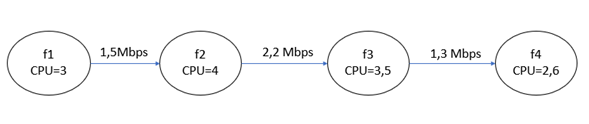

In the other hand the processing and treatment of date is done in the physical structure composed of different physical objects offering limited CPU processing and limited amount of bandwidth between two nodes. As we can see in the following example:

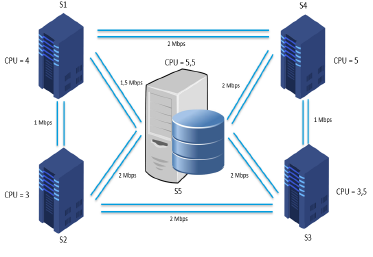

This is represented by a undirected graph, with each node as a physical structure allowing to process the date and with the edges for the limited bandwidth between each other.
The goal is to locate each virtual function (node of the virtual graph) in a physical structure (node of the physical graph) by maximizing the remaining bandwidth in edges and CPU in nodes.
To tackle this problem there are different approaches such as Integer Linear Programming and Graph-based approach, nevertheless these approaches have a high complexity and require long time to deliver solutions, which is non-desirable in dynamic systems with frequent changes of requirements. 
The solution that we are going to show in this report allows to have lower times of solving by using  Q-Learning which is a type Reinforcement Learning algorithm.


In [ ]:
!pip install networkx 

In [ ]:
import networkx as nx
nx.__version__
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

np.set_printoptions(threshold=np.inf)

To modelize the problem, we need to create two types of graphes, a virtual graph made of 4 nodes and 3 edges, and a physical one,a connex graph made of random number of nodes and random number of edges. 

# 1 Generation of Graph

## 1.1 Graphe Virtuel


Thus we create the virtual graph, with the use of the library networkx. 
We get random values for the CPU and the weights, allowing us to have random graphes and not fixed ones, so that we can generalise our study. 

Generation of Nodes with random values of CPU


In [ ]:
G_virtuel=nx.DiGraph()
GV=[]
a=random.uniform(3,7)
b=random.uniform(3,7)
c=random.uniform(3,7)
d=random.uniform(3,7)
G_virtuel.add_node('f1',CPU = a)
GV.append(a)
G_virtuel.add_node('f2',CPU = b)
GV.append(b)

G_virtuel.add_node('f3',CPU = c)
GV.append(c)
G_virtuel.add_node('f4',CPU = d)
GV.append(d)
G_virtuel.nodes.data()
print(GV)

[6.613659186829462, 3.382705309965091, 4.380347794562082, 5.89580568656067]


Generation of edges with random values of weigts 

In [ ]:
GW=[]
a2=random.uniform(4,7)
b2=random.uniform(4,7)
c2=random.uniform(4,7)
G_virtuel.add_weighted_edges_from([('f1','f2',{'weight': a2}),('f2','f3',{'weight': b2}),('f3','f4',{'weight': c2})]) 
GW.append(a2)
GW.append(b2)
GW.append(c2)
print(GW)



[4.392362795812517, 5.94255204245919, 5.4421591756919]


In [ ]:
position = { 'f1':(-1,0),
        'f2':(0,0),
        'f3':(1,0),
        'f4':(2,0),
}

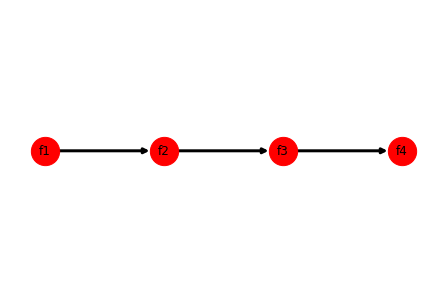

In [ ]:
nx.draw(G =G_virtuel,
      with_labels=True, 
      edge_color='black',
      pos=position,
      node_color='r', # r = red
       node_size=800, 
       width=3, 
     )
plt.savefig("G_virtuel.jpg")
plt.show()

In [ ]:
list(G_virtuel.nodes)

['f1', 'f2', 'f3', 'f4']

In [ ]:
list(G_virtuel.edges)

[('f1', 'f2'), ('f2', 'f3'), ('f3', 'f4')]

## 1.2 Graphe physique

We also create the physical graph for the study. It is a connex graph, that have a random number of nodes with each a random value of cpu, and a random number of edges between the nodes, each with a random value of bandwhich. 

We can print the Graph, the list of edges, nodes and weights : 

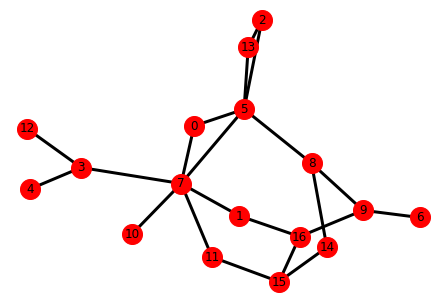

[[32.41581826  0.          0.          0.          0.         41.22157388
   0.         47.26897652  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         44.26704275  0.          0.          0.          0.
   0.          0.          0.          0.         45.38399767]
 [ 0.          0.          0.          0.          0.         31.04006459
   0.          0.          0.          0.          0.          0.
   0.         40.11560812  0.          0.          0.        ]
 [ 0.          0.          0.         33.60907382 48.6497595   0.
   0.         31.00706545  0.          0.          0.          0.
  36.43378729  0.          0.          0.          0.        ]
 [ 0.          0.          0.         48.6497595   0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [41.2215

In [ ]:
G_physique=nx.Graph()


###Nodes : 
n = random.randint(10,30)
cpu=0
L=np.zeros((n,n))
N=[]



for i in range(n):
    cpu=random.uniform(30,50)
    G_physique.add_node(str(i),CPU = cpu )
    N.append(cpu)

### Edges : 
edges=[]
connected=np.zeros(n)
l=0
nb_edges=random.randint(20,30)

while l< nb_edges:
  i=random.randint(0,n-1)
  j=random.randint(0,n-1)
  if (i,j) not in edges :
    if  (j,i) not in edges :
      edges.append((i,j))
      e = random.uniform(30,50)
      G_physique.add_edge(str(i), str(j), weight=e)
      L[i][j]= e 
      L[j][i] = e
      l+=1
      connected[i]=1
      connected[j]=1
    else :
      l=l+0 

k=0
for i in connected:
  if i == 0 :
    while 1:
      j=random.randint(0,n-1)
      if j != k:
        break
    edges.append((k,j))
    e = random.uniform(30,50)
    G_physique.add_edge(str(i), str(j), weight=e)
    L[k][j] = e 
    L[j][k] = e
    connected[k]=1
    connected[j]=1
  k+=1

G_physique.nodes.data()
nx.draw(G =G_physique,
      with_labels=True, 
      edge_color='black',
      node_color='r', # r = red
       node_size=400, 
       width=3, 
     )


plt.show()
print(L)

# 2 Algorithme de Reinforcement learning 


## 2.1 Graphe

In [ ]:
def G_virtuel():
  G_virtuel=nx.DiGraph()
  GV=[]
  a=random.uniform(3,7)
  b=random.uniform(3,7)
  c=random.uniform(3,7)
  d=random.uniform(3,7)
  G_virtuel.add_node('f1',CPU = a)
  GV.append(a)
  G_virtuel.add_node('f2',CPU = b)
  GV.append(b)

  G_virtuel.add_node('f3',CPU = c)
  GV.append(c)
  G_virtuel.add_node('f4',CPU = d)
  GV.append(d)
  G_virtuel.nodes.data()


  GW=[]
  a2=random.uniform(4,7)
  b2=random.uniform(4,7)
  c2=random.uniform(4,7)
  G_virtuel.add_weighted_edges_from([('f1','f2',{'weight': a2}),('f2','f3',{'weight': b2}),('f3','f4',{'weight': c2})]) 
  GW.append(a2)
  GW.append(b2)
  GW.append(c2)

  return (GV,GW)

And we do the same with the physical graph, by creating the function G_physique1 : 


In [ ]:
def G_physique1():

  G_physique=nx.Graph()
###Nodes : 
  n = random.randint(10,30)
  cpu=0
  L=np.zeros((n,n))
  N=[]
  for i in range(n):
      cpu=random.uniform(30,50)
      G_physique.add_node(str(i),CPU = cpu )
      N.append(cpu)
  edges=[]
  connected=np.zeros(n)
  l=0
  nb_edges=random.randint(20,30) #the upper number of range should be bounded by the number of combination of all nodes to avoid an inifinity loop

  while l< nb_edges:
    i=random.randint(0,n-1)
    j=random.randint(0,n-1)
    if (i,j) not in edges :
      if  (j,i) not in edges :
        edges.append((i,j))
        e = random.uniform(30,50)
        G_physique.add_edge(str(i), str(j), weight=e)
        L[i][j]= e 
        L[j][i] = e
        l+=1
        connected[i]=1
        connected[j]=1
      else :
        l=l+0 

  k=0
  for i in connected:
    if i == 0 :
      while 1:
        j=random.randint(0,n-1)
        if j != k:
          break
      edges.append((k,j))
      e = random.uniform(30,50)
      G_physique.add_edge(str(i), str(j), weight=e)
      L[k][j] = e 
      L[j][k] = e
      connected[k]=1
      connected[j]=1
    k+=1

  G_physique.nodes.data()
  return (N,L)

## 2.2 Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. For every episode, we choose the first state by deploying the virtual function on the physical node that has the maximum CPU capacity. 
2. Choose an action which means the next physical code to take for the current state. Actions will be chosen using an *epsilon greedy algorithm. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state.
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.


In [ ]:
def reinforcement(N,GV,L,GW):

  ##### DECLERATION OF PARAMETERS #####
  #matrix of Q value whose size is 3*NumberOfNodes*NumberOfNodes
  Q = np.zeros((3,len(N),len(N)))

  #hyperparmeters
  alpha = 0.9   #the rate at which the AI agent should learn
  gamma = 0.9  #discount factor for future rewards
  epsilon = 1.00   #the probability of choosing "exploration"

  decay_rate = 0.9  #the rate which decreases the probability epsilon 
  Number_of_episode = 1000 

  #initialization of episode
  ep=0

  ##### WHOLE LOOP #####
  while ep <= Number_of_episode:
    #initialization
    t=0 #counter variable for inner loop
    max_capacity = 0 #to conserve the maximum cpu value
    current_node_number = 0 #variable to stock cuurent node number
    #reset all the values of phisical and virtual graphs
    node_p = copy.deepcopy(N)
    node_v = copy.deepcopy(GV)
    band_p = copy.deepcopy(L)
    band_v = copy.deepcopy(GW)

    #choose the initial node which have the maximum cpu value
    for i in range(len(node_p)):
      if max_capacity < node_p[i]:
        max_capacity = node_p[i]
        current_node_number = i #update current node number

    #update the CPU value
    node_p[current_node_number] -= node_v[0]
    
    ##### INNER LOOP #####
    while t < 3: #t=0 is for from f1 to f2, t=1 is for from f2 to f3, and t=2 is for from f3 to f4
      #choose randamly Exploration with the probability 1-epsilon(resp. choose randamly Exploitation with the probablility epsilon)
      Exploration = random.choices([0,1], k=1, weights=[1-epsilon,epsilon])

      ##### EXPLORATION #####
      if Exploration:
        #select the next node in a random manner
        i=0 #counter variable for the loop to choose the next node
        while i < 30: #set the maximum trial number to avoid the infinity loop in the case that there is no node which satisfies the conditions
          random_node_number = random.randint(0,len(node_p)-1) 
          if node_p[random_node_number] >= node_v[t+1] and band_v[t] < band_p[current_node_number][random_node_number]:
            selected_node_number = random_node_number #set the next node if it is feasible
            break
          i+=1
          if i == 30:
            selected_node_number = -1 #set -1 when the next node isn't found

      ##### EXPLOITATION #####
      else:
        #select the next node according to the function pi: pi = argmax_At (Q(St,At))
        pi = 0
        selected_node_number = -1
        for next_node_number in range(len(Q[t][current_node_number])):
          if pi < Q[t][current_node_number][next_node_number] and node_p[random_node_number] >= node_v[t+1] and band_v[t] < band_p[current_node_number][random_node_number]:
            pi = Q[t][current_node_number][next_node_number]
            selected_node_number = next_node_number #update selected_node_number 

      #If there is no node which satisfies the conditions, stop searching and escape the loop
      if selected_node_number == -1:
        t = 3
      else:
        #update the CPU value
        node_p[selected_node_number] -= node_v[t+1]
        #update the bandwidth value
        band_p[current_node_number][selected_node_number] -= band_v[t]
        band_p[selected_node_number][current_node_number] -= band_v[t]

        #calculate reward
        reward = 0
        reward += band_p[current_node_number][selected_node_number]
        reward += node_p[selected_node_number]

        #calculate future reward
        future_reward = 0
        if t < 2: #if t=2, there is no future reward
          for next_node_number in range(len(Q[t+1][selected_node_number])):
            if future_reward < Q[t][selected_node_number][next_node_number]:
              future_reward = Q[t][selected_node_number][next_node_number]

        #update Q-value
        Q[t][current_node_number][selected_node_number] += alpha*(reward + gamma*future_reward - Q[t][current_node_number][selected_node_number])

        #update state
        current_node_number = selected_node_number
        t += 1

    #decrease the probability epsilon accoding to the decay rate
    epsilon *= decay_rate

    #update episode number
    ep += 1 
  
  return Q #return the reinforced Q-table

## 2.3 Get the optimal solution
Now that the AI agent has been fully trained, we just use it to find the optimal solution for the embedding problem. 

In [ ]:
def optimal_solution(Q,N,GV,L,GW):

  #initialization
  t=0 #counter variable for inner loop
  max_capacity = 0 #to conserve the maximum cpu value
  current_node_number = 0 #variable to stock current node number
  f = [-1,-1,-1,-1] #list to stock the optimal solution
  #set all the values of phisical and virtual graphs to each variable
  node_p = copy.deepcopy(N)
  node_v = copy.deepcopy(GV)
  band_p = copy.deepcopy(L)
  band_v = copy.deepcopy(GW)

  #choose the initial node which have the maximum cpu value
  for i in range(len(node_p)):
    if max_capacity < node_p[i]:
      max_capacity = node_p[i]
      current_node_number = i #update current node number

  #allocate the current node number to the first element of the solution list f
  f[0] = current_node_number

  #update CPU value
  node_p[current_node_number] -= node_v[0]
    
  while t < 3:
    ##### EXPLOITATION #####
    #select the next node according to the function pi: pi = argmax_At (Q(St,At))
    pi = 0
    selected_node_number = -1
    for next_node_number in range(len(Q[t][current_node_number])):
      if pi < Q[t][current_node_number][next_node_number] and node_p[next_node_number] >= node_v[t+1] and band_v[t] < band_p[current_node_number][next_node_number]:
        pi = Q[t][current_node_number][next_node_number]
        selected_node_number = next_node_number

    #if there is no node which satisfy conditions, stop searching and escape the loop
    if selected_node_number == -1:
      t = 3
    else:
      #update CPU value
      node_p[selected_node_number] -= node_v[t+1]
      #update bandwidth value
      band_p[current_node_number][selected_node_number] -= band_v[t]
      band_p[selected_node_number][current_node_number] -= band_v[t]

      #update state
      current_node_number = selected_node_number
      t += 1
      f[t] = current_node_number #allocate the current node number to f[t]

  #update phisical graph
  N = node_p
  L = band_p

  return f,N,L #retrun the opitmal solution and updated phisical graph

# 3 Dynamique

Now that we could find solution for a static virtual Graph, we will study a more accurate case : the case of dynamic virtual graph arriving and needed to be positioned on the physical graph. For that we will use the principal of arrival and interarrival Poisson process.


In [ ]:
T=1.0000000001
X=0 #we initialise the X variable to 0 
Y=0 #we initialise the Y variable to 0 
t=time.time() # to have a time we set a variable at the time we lunch the block
while time.time()<T*t: #we compare it to the time we run this line to T*t, t the time we took just before
  X+= np.random.exponential(50) # X follows an exponential law to respect the poisson process
  H=Y # we set H beeing the time of life of the previous graph
  Y+= np.random.exponential(10) # Y is the time of life of the graph we are implementing 
  if time.time()>X and time.time()>X+H: # if the time is bigger then the time the new graph arrives and the other graph is over we run the code
    GV,GW =G_virtuel()
    Q=reinforcement(N,GV,L,GW)
    f_optimal, N, L = optimal_solution(Q,N,GV,L,GW) # we finf the optimal solution for the graph we are studying and we update the physical graph to take into acount that solution 
    print(f_optimal)
    print('          graphe suivant : ')

[7, 0, 13, 0]
          graphe suivant : 


# 4 Calcul du taux de solution 


Finally, we want to see the percentage of solution found, so we create a loop where we generate a random virtual graph, and a random physical graph and if a solution exists we count it, if not we don't. This will give us a rate to see the percentage of success into finding a solution ( the percentage of success depends on the number of edges we defined in the definition of the graphs. The more edges, the more likely the rate will be high ) 

In [ ]:
i=0  # we initiate the loop variable to 0 
S=0  # we initiate the count variable to 0
G=100  # we set the number of iteration we want to do to mesure the rate
while i<G:
  GV1,GW1 =G_virtuel() #we generate a random virtuel graph
  N1,L1= G_physique1() #we generate a random physical graph
  Q=reinforcement(N1,GV1,L1,GW1)
  f_optimal = optimal_solution(Q,N1,GV1,L1,GW1)[0] # we find the optimal solution for the graph we are studying and we update the physical graph to take into acount that solution 
  print(f_optimal) # we print it
  if -1  in f_optimal:  #we set a condition, if -1 is in the last solution, then no solution was found and we don't count it 
    S+=0
  else:  # if a solution was found, we count it 
    S+=1
  i+=1
print(S/G) # we see the rate of found solution 

[5, 4, 4, 9]
[11, 23, 22, 23]
[17, 6, 16, 19]
[2, 9, 5, 2]
[1, 3, 6, 0]
[2, 9, 5, 6]
[1, 7, 2, 3]
[0, 0, 6, 1]
[0, 6, 0, 6]
[2, 3, 2, 4]
[7, 0, 14, 7]
[1, 9, 7, 3]
[19, 6, 16, 0]
[18, 0, 11, 0]
[5, 22, 13, 23]
[4, 8, 4, 8]
[2, 27, 23, 27]
[21, 18, 27, 0]
[16, 0, 7, 11]
[4, 10, 0, 10]
[8, 8, 5, 11]
[13, 19, 18, 27]
[13, 0, 27, 0]
[0, 4, 0, 4]
[21, 10, 1, 10]
[1, 15, 1, 15]
[3, 7, 1, 9]
[13, 2, 12, 6]
[8, 6, 10, 6]
[13, 24, 13, 24]
[7, 8, 13, 5]
[3, 5, 3, 18]
[17, 16, 4, 16]
[8, 2, 3, 0]
[4, 5, 4, 5]
[12, 8, 6, 10]
[4, 13, 4, 13]
[3, 7, 10, 7]
[9, 12, 11, 3]
[8, 10, 6, 1]
[5, 0, 5, 0]
[6, 12, 14, 15]
[3, 21, 3, 21]
[2, 15, 2, 5]
[9, 8, 1, 10]
[0, 10, 0, 10]
[21, -1, -1, -1]
[10, 14, 10, 14]
[11, 4, 12, 11]
[1, 1, 8, 1]
[8, 1, 14, 2]
[14, 16, 14, 16]
[21, 13, 21, 13]
[20, 6, 20, 0]
[0, 4, 0, 7]
[12, 17, 13, 7]
[7, 12, 12, 7]
[0, 9, 5, 1]
[4, 0, 8, 10]
[4, 3, 11, 3]
[9, 13, 1, 5]
[3, 21, 13, 4]
[12, 19, 12, 19]
[3, 5, 9, 3]
[13, 9, 9, 13]
[16, 13, 13, 5]
[2, 4, 1, 6]
[20, 6, 20, 6]
[0, 0, 